In [1]:
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import warnings
warnings.filterwarnings('ignore')

О сборе датасета: я скачала несколько репозиториев с гитхаба и пропустила их через скрипт `parser.py`. Старалась подбирать репозитории с короткими файлами, но чтобы их было много. В основном брала репозитории, в которые люди выкладывали решения задач курса по какому-то языку. Например, файлы на С++ - это конспекты курса по С++, который я проходила год назад.

Также в датасет добавлены файл, который получился на практике по данным из телеграма.

# Easy

## Предобработка

In [3]:
df = pd.read_csv('../../data/github_code.csv')
df.head()

,Unnamed: 0,text,language
0,0,import service\n\n\ndef main():\n show_head...,PYTHON
1,1,from collections import namedtuple\nfrom xml.e...,PYTHON
2,2,"def show_header():\n print(""---------------...",PYTHON
3,3,import random\nfrom shared_libs import ui_help...,PYTHON
4,4,import pandas as pd\nimport matplotlib.pyplot ...,PYTHON


In [4]:
df['language'].value_counts()

language
JAVASCRIPT    1020
PYTHON         835
CPLUSPLUS      735
Name: count, dtype: int64

In [5]:
df_tg = pd.read_csv('../../data/tg_code.csv')
df_tg['language'].value_counts()

language
text             79845
CPLUSPLUS          208
YAML                78
HASKELL             69
SQL                 69
FORTRAN             59
PYTHON              55
POWERSHELL          53
PERL                44
JAVA                41
TYPESCRIPT          40
RUST                39
R                   31
JULIA               30
PHP                 29
OCAML               28
FSHARP              27
JAVASCRIPT          26
DELPHI              25
GO                  24
COBOL               23
ASSEMBLY            22
ELIXIR              19
LATEX               18
KOTLIN              18
CRYSTAL             17
C                   17
ELM                 16
PASCAL              15
ERLANG              15
SCALA               14
AUTOHOTKEY          14
LUA                 14
FORTH               13
DART                13
CLOJURE             12
NIM                 11
BASIC               10
D                   10
RUBY                10
BATCH                9
eth                  8
1S_ENTERPRISE        8
CS

In [6]:
df_tg = df_tg.loc[df_tg['language'].isin(['CPLUSPLUS', 'PYTHON', 'JAVASCRIPT', 'text'])]
df_tg['language'].value_counts()

language
text          79845
CPLUSPLUS       208
PYTHON           55
JAVASCRIPT       26
Name: count, dtype: int64

In [7]:
df_tg['is_tg'] = True
df['is_tg'] = False
df = pd.concat([df_tg, df])
df.reset_index(drop=True, inplace=True)
filtered_df = df[df['language'] == 'text']
rows_to_remove = filtered_df.sample(n=79000, random_state=42).index
df.drop(rows_to_remove, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.to_csv('../../data/code_merged.csv')

In [8]:
df['language'].value_counts()

language
JAVASCRIPT    1046
CPLUSPLUS      943
PYTHON         890
text           845
Name: count, dtype: int64

In [9]:
def preprocess_code(code, language):
    if language in ['CPLUSPLUS', 'PYTHON', 'JAVASCRIPT']:
        code = re.sub(r'#.*?(\n|$)', '', code)
        code = re.sub(r'//.*?(\n|$)', '', code)
        code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    
    if language != 'text':
        code = re.sub(r'[а-яА-ЯёЁ]+', '', code)
    
    code = re.sub(r'\s+', ' ', code)
    return code

In [10]:
# languages = list(df['language'])
snippets = [preprocess_code(str(df['text'][i]), str(df['language'][i])) for i in df.index]
df['text'] = snippets

## Обучение

Используем tfidf + наивный байесовский классификатор. На практике использовали tfidf для выделения фичей из пунктуации, он дал не самый лучший скор. Я предпочту использовать его же, но для всего текста, т.к. на мой взгляд некоторые синтаксические конструкции могут быть важной фичей некоторых языков программирования. В пару к нему возьмем наивный байес, т.к. он хорошо может определить, какие синтаксические конструкции в каком языке встречаются чаще.

In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train['text']
X_test = test['text']
y_train = train['language']
y_test = test['language']
# X_train, X_test, y_train, y_test = train_test_split(snippets, languages, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [12]:
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)

y_pred = classifier.predict(X_test_vect)
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Balanced accuracy: 0.9122182906324001
              precision    recall  f1-score   support

   CPLUSPLUS       0.96      0.94      0.95       188
  JAVASCRIPT       0.83      0.98      0.90       201
      PYTHON       0.94      0.94      0.94       183
        text       0.97      0.80      0.87       173

    accuracy                           0.92       745
   macro avg       0.92      0.91      0.91       745
weighted avg       0.92      0.92      0.92       745



Отдельно провалидируемся на сэмплах из телеграма.

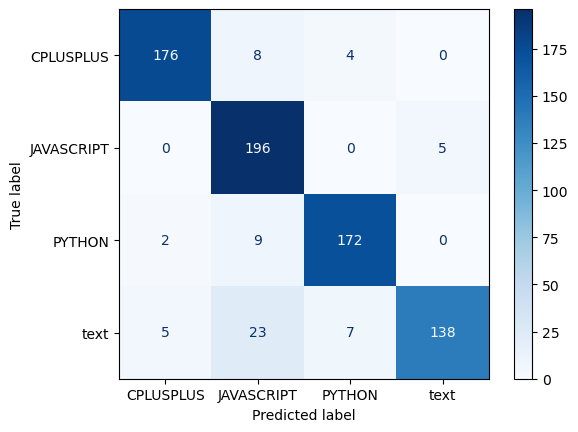

In [13]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.language))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
test_tg = test[test['is_tg'] == True]
X_test_tg = test_tg['text']
y_test_tg = test_tg['language']
X_test_tg_vect = vectorizer.transform(X_test_tg)

y_pred_tg = classifier.predict(X_test_tg_vect)
print(f'Balanced accuracy: {balanced_accuracy_score(y_test_tg, y_pred_tg)}')
print(classification_report(y_test_tg, y_pred_tg))

Balanced accuracy: 0.7890052986512525
              precision    recall  f1-score   support

   CPLUSPLUS       0.82      0.73      0.78        45
  JAVASCRIPT       0.20      1.00      0.34         9
      PYTHON       0.48      0.62      0.54        16
        text       1.00      0.80      0.89       173

    accuracy                           0.78       243
   macro avg       0.63      0.79      0.64       243
weighted avg       0.90      0.78      0.82       243



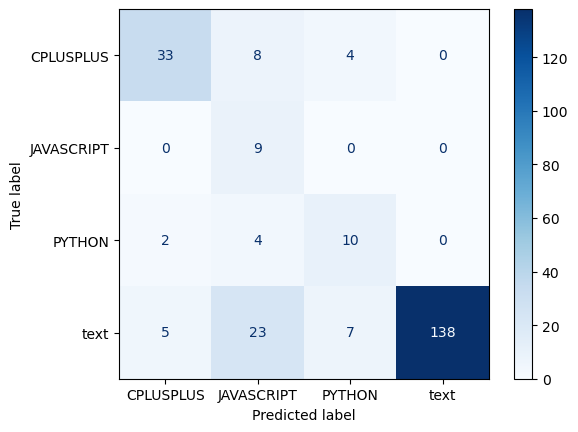

In [15]:
cm = confusion_matrix(y_test_tg, y_pred_tg)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.language))
disp.plot(cmap=plt.cm.Blues)
plt.show()

Предполагаю, что модель может путать пару javascript и python в силу схожего синтаксиса. Поскольку качество датасета сообщений из телеграма не идеально, дело может быть либо в неверном парсинге, либо в целом в неверном понимании синтаксиса моделью. При это наблюдается явный перекос в сторону javascipt (у него recall = 1) - возможно, это из-за легкого дисбаланса классов в датасете.

Сохраним модель, обученную на всем датасете, для улучшения итогового качества.

In [16]:
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("model", MultinomialNB()),
    ]
)
pipeline.fit(df['text'], df['language'])

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('model', MultinomialNB())])

In [17]:
with open('model_prog.pickle', 'wb') as file:
    pickle.dump(pipeline, file)

## Тест скрипта

In [18]:
! python3 main.py python_code1.txt

PYTHON


In [19]:
! python3 main.py python_code2.txt

PYTHON


In [20]:
! python3 main.py python_code3.txt

PYTHON


In [21]:
! python3 main.py javascript_code1.txt

JAVASCRIPT


In [22]:
! python3 main.py javascript_code2.txt

JAVASCRIPT


In [23]:
! python3 main.py javascript_code3.txt

JAVASCRIPT


In [24]:
! python3 main.py c++_code1.txt

CPLUSPLUS


In [25]:
! python3 main.py c++_code2.txt

CPLUSPLUS


In [26]:
! python3 main.py c++_code3.txt

CPLUSPLUS


# Medium

Датасет с сообщениями из телеграма изменен: туда добавлено еще несколько чатов. Они пропущены через код обработки датасета с практики.

Для некоторых языков программирования у меня не получилось найти чаты, либо они были слишком большими и их скачка занимала очень много времени. В целом из просмотра данных глазами кажется, в программистские чаты не слишком часто присылают код, а также часто присылают код на другом языке программирования, поэтому получение данных таким путем - это очень времязатратно.

In [27]:
df_gh = pd.read_csv('../../data/github_code_medium.csv')
df_gh['language'].value_counts()

language
MARKDOWN      1079
JAVASCRIPT    1020
PYTHON         835
CPLUSPLUS      735
JAVA           467
KOTLIN         179
POWERSHELL     165
HASKELL        145
C              139
YAML           120
Name: count, dtype: int64

In [28]:
df_tg = pd.read_csv('../../data/tg_code_medium.csv')
df_tg = df_tg.loc[df_tg['language'].isin(['CPLUSPLUS', 'PYTHON', 'JAVASCRIPT', 'JAVA', 'C', 'HASKELL', 'KOTLIN', 
                                          'YAML', 'POWERSHELL', 'text'])]
df_tg.drop(columns=['0'], inplace=True)
df_tg['language'].value_counts()

language
text          206485
CPLUSPLUS        208
HASKELL           99
YAML              78
PYTHON            57
POWERSHELL        54
JAVA              41
JAVASCRIPT        26
KOTLIN            18
C                 18
Name: count, dtype: int64

In [29]:
df_tg['is_tg'] = True
df_gh['is_tg'] = False
df_tg['top_level_dir'] = [str(i) for i in range(1, len(df_tg) + 1)] # разные значения для сообщений из тг
# df_tg['top_level_dir'] = 'telegram' # плохие метрики
filtered_df = df_tg[df_tg['language'] == 'text']
rows_to_remove = filtered_df.sample(n=205500, random_state=42).index
df_tg.drop(rows_to_remove, inplace=True)
df_tg.reset_index(drop=True, inplace=True)
df = pd.concat([df_tg, df_gh])
df.reset_index(drop=True, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.to_csv('../../data/code_merged_medium.csv')

In [30]:
df['language'].value_counts()

language
MARKDOWN      1079
JAVASCRIPT    1046
text           985
CPLUSPLUS      943
PYTHON         892
JAVA           508
HASKELL        244
POWERSHELL     219
YAML           198
KOTLIN         197
C              157
Name: count, dtype: int64

In [31]:
def preprocess_code(code, language):
    # Remove comments based on the language
    if language in ['CPLUSPLUS', 'C', 'JAVA', 'JAVASCRIPT', 'KOTLIN']:
        code = re.sub(r'//.*?(\n|$)', '', code)
        code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    
    if language == 'PYTHON':
        code = re.sub(r'#.*?(\n|$)', '', code)

    if language == 'HASKELL':
        code = re.sub(r'--.*?(\n|$)', '', code) 
        code = re.sub(r'\{-(.|\n)*?-\}', '', code, flags=re.DOTALL)

    if language == 'YAML':
        code = re.sub(r'#.*?(\n|$)', '', code) 

    if language == 'POWERSHELL':
        code = re.sub(r'#.*?(\n|$)', '', code)
        
    if language == 'markdown':
        code = re.sub(r'<!--.*?-->', '', code, flags=re.DOTALL) 

    if language != 'text':
        code = re.sub(r'[а-яА-ЯёЁ]+', '', code)

    code = re.sub(r'\s+', ' ', code)
    
    return code

In [32]:
snippets = [preprocess_code(str(df['text'][i]), str(df['language'][i])) for i in df.index]
df['text'] = snippets

In [33]:
df.head()

,text,language,is_tg,top_level_dir
0,flex-direction: column,JAVASCRIPT,True,1
1,div { display: flex; max-width: 100%; overflow...,JAVASCRIPT,True,2
2,.category-item > a { display: block; } .catego...,JAVASCRIPT,True,3
3,const ADDITIONAL_BLOCK_TYPE = { ClientDownload...,JAVASCRIPT,True,4
4,const ADDITIONAL_BLOCK_TYPE = { CLIENTDOWNLOAD...,JAVASCRIPT,True,5


In [34]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
'''train_indices, test_indices = custom_train_test_split(df, test_size=0.2, random_state=42)
train = df.loc[train_indices]
test = df.loc[test_indices]'''

X_train = train['text']
X_test = test['text']
y_train = train['language']
y_test = test['language']

vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [35]:
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)

y_pred = classifier.predict(X_test_vect)
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Balanced accuracy: 0.6178480851566984
              precision    recall  f1-score   support

           C       1.00      0.13      0.23        23
   CPLUSPLUS       0.87      0.90      0.88       202
     HASKELL       1.00      0.21      0.35        62
        JAVA       0.93      0.86      0.89        93
  JAVASCRIPT       0.73      0.98      0.84       197
      KOTLIN       1.00      0.64      0.78        36
    MARKDOWN       0.61      0.97      0.75       234
  POWERSHELL       1.00      0.10      0.17        42
      PYTHON       0.97      0.80      0.87       166
        YAML       1.00      0.40      0.57        43
        text       0.99      0.81      0.89       196

    accuracy                           0.80      1294
   macro avg       0.92      0.62      0.66      1294
weighted avg       0.86      0.80      0.78      1294



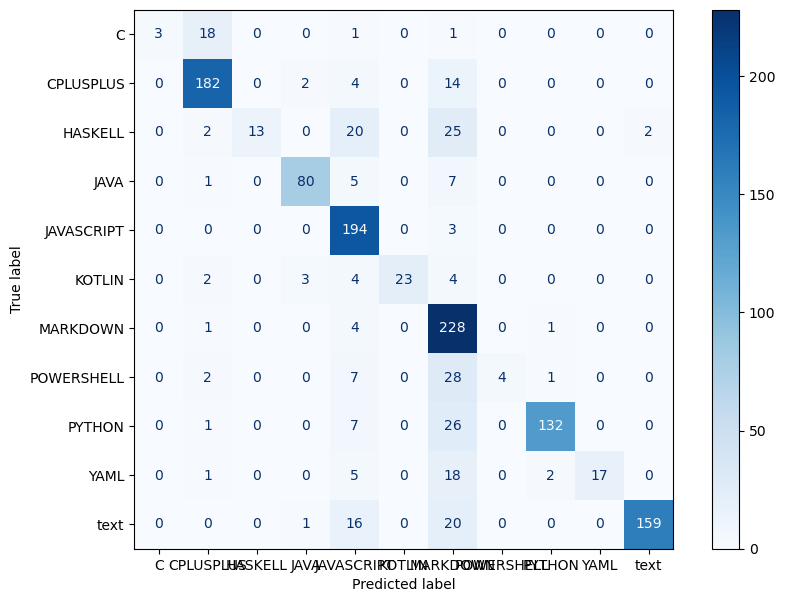

In [36]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.language))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.show()

Не очень хорошие метрики - результат дисбаланса классов и возможного переобучения на файлах с гитхаба. Отдельно провалидируемся на сэмплах из телеграма. 

In [37]:
test_tg = test[test['is_tg'] == True]
X_test_tg = test_tg['text']
y_test_tg = test_tg['language']
X_test_tg_vect = vectorizer.transform(X_test_tg)

y_pred_tg = classifier.predict(X_test_tg_vect)
print(f'Balanced accuracy: {balanced_accuracy_score(y_test_tg, y_pred_tg)}')
print(classification_report(y_test_tg, y_pred_tg))

Balanced accuracy: 0.29661479976606026
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
   CPLUSPLUS       0.80      0.63      0.70        51
     HASKELL       0.00      0.00      0.00        30
        JAVA       0.40      0.14      0.21        14
  JAVASCRIPT       0.10      1.00      0.19         6
      KOTLIN       0.00      0.00      0.00         4
    MARKDOWN       0.00      0.00      0.00         0
  POWERSHELL       0.00      0.00      0.00         7
      PYTHON       0.62      0.38      0.48        13
        YAML       0.00      0.00      0.00        16
        text       0.99      0.81      0.89       196

    accuracy                           0.60       340
   macro avg       0.27      0.27      0.22       340
weighted avg       0.73      0.60      0.65       340



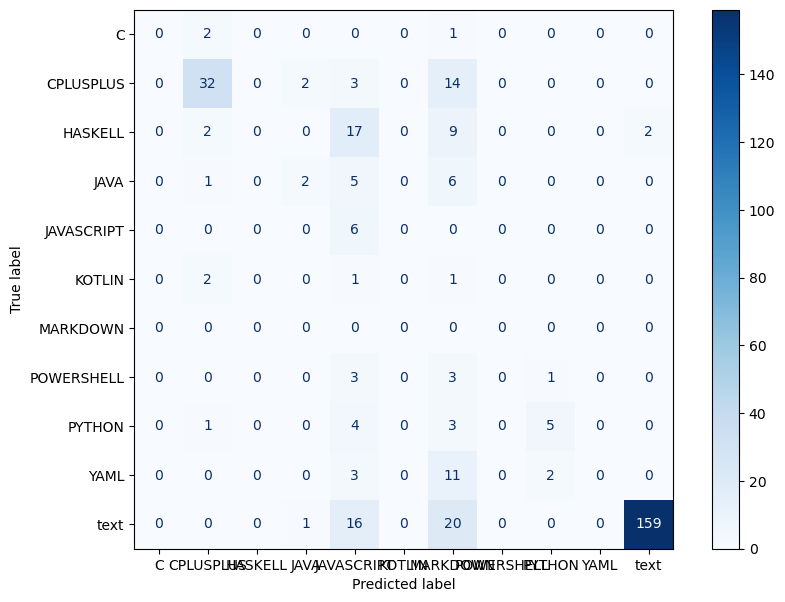

In [38]:
cm = confusion_matrix(y_test_tg, y_pred_tg)

plt.figure(figsize=(10, 7)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.language))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.show()

Самые малочисленные классы получили 0, что довольно логично. Попробуем разбивать на тест и трейн по директориям.

In [39]:
def custom_train_test_split(df, test_size=0.2, random_state=None):
    unique_top_level_dirs = df['top_level_dir'].unique()
    train_top_level_dirs, test_top_level_dirs = train_test_split(unique_top_level_dirs, test_size=test_size, random_state=random_state)

    train_indices = df[df['top_level_dir'].isin(train_top_level_dirs)].index
    test_indices = df[df['top_level_dir'].isin(test_top_level_dirs)].index

    return train_indices, test_indices

In [40]:
train_indices, test_indices = custom_train_test_split(df, test_size=0.2, random_state=42)
train = df.loc[train_indices]
test = df.loc[test_indices]

X_train = train['text']
X_test = test['text']
y_train = train['language']
y_test = test['language']

vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [41]:
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)

y_pred = classifier.predict(X_test_vect)
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Balanced accuracy: 0.42006315055605437
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         4
   CPLUSPLUS       0.43      0.80      0.56        49
     HASKELL       0.00      0.00      0.00       114
        JAVA       0.48      0.62      0.54        21
  JAVASCRIPT       0.01      1.00      0.02         7
      KOTLIN       0.00      0.00      0.00         4
    MARKDOWN       0.98      0.76      0.85       834
  POWERSHELL       0.00      0.00      0.00        82
      PYTHON       0.98      0.61      0.75       502
        YAML       0.00      0.00      0.00        67
        text       0.99      0.84      0.91       187

    accuracy                           0.62      1871
   macro avg       0.35      0.42      0.33      1871
weighted avg       0.81      0.62      0.69      1871



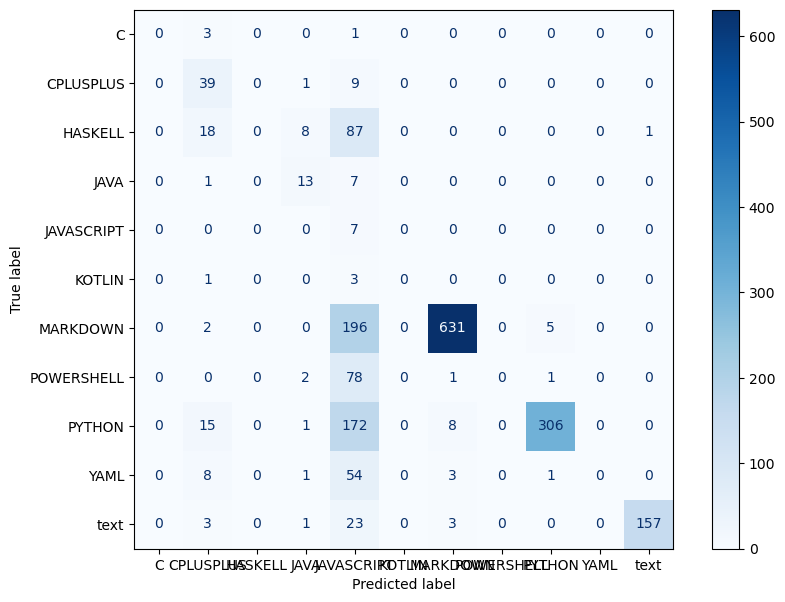

In [42]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.language))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.show()

Стало сильно хуже: самые малочисленные классы совсем не выучились. Предполагаю, что из-за того, что некоторые директории содержат очень много файлов, они целиком попадают в трейн или тест, и т.к. модель знает какие-то несколько проектов слишком хорошо, вплоть до названий переменных, она не может обобщить свои знания на другие. Тут можно либо попробовать совсем другую модель, либо увеличить выборку за счет более мелких репозиториев, либо не использовать этот способ разбиения.

Отдельно попробуем обучиться на файлах с гитхаба и провалидировать на сообщениях из телеграма.

In [43]:
snippets = [preprocess_code(str(df_gh['text'][i]), str(df_gh['language'][i])) for i in df_gh.index]
df_gh['text'] = snippets
snippets = [preprocess_code(str(df_tg['text'][i]), str(df_tg['language'][i])) for i in df_tg.index]
df_tg['text'] = snippets

In [44]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(df_gh['text'])
X_test_vect = vectorizer.transform(df_tg['text'])
y_train = df_gh['language']
y_test = df_tg['language']

classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)

y_pred = classifier.predict(X_test_vect)
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Balanced accuracy: 0.15630657318718938
              precision    recall  f1-score   support

           C       0.00      0.00      0.00        18
   CPLUSPLUS       0.51      0.23      0.32       208
     HASKELL       0.00      0.00      0.00        99
        JAVA       0.45      0.24      0.32        41
  JAVASCRIPT       0.11      0.81      0.20        26
      KOTLIN       0.00      0.00      0.00        18
    MARKDOWN       0.00      0.00      0.00         0
  POWERSHELL       0.00      0.00      0.00        54
      PYTHON       0.46      0.28      0.35        57
        YAML       0.00      0.00      0.00        78
        text       0.00      0.00      0.00       985

    accuracy                           0.06      1584
   macro avg       0.14      0.14      0.11      1584
weighted avg       0.10      0.06      0.07      1584



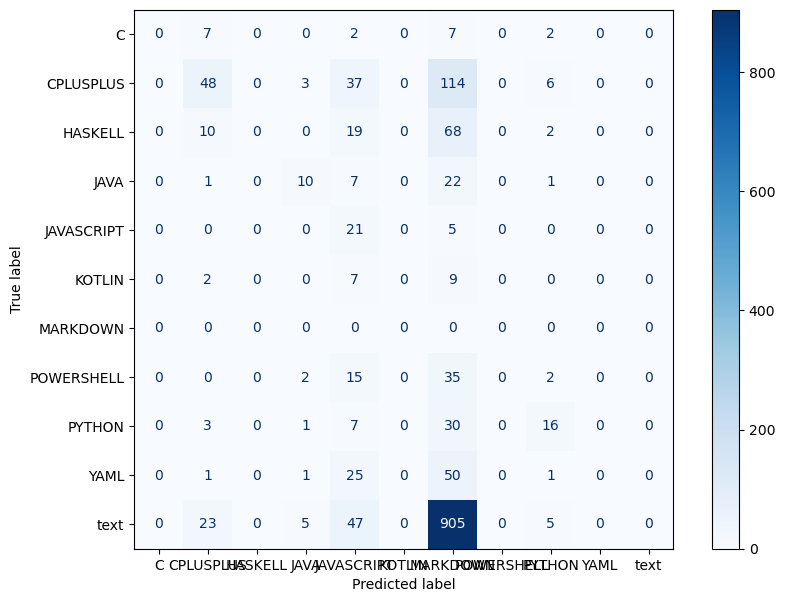

In [45]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.language))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.show()

На малочисленных классах (не считая текста и markdown, которые целиком представлены в разных выборках) все плохо. На многочисленных кажется чуть лучше, но без явной корреляции с размером выборки.

Видимо, "распределение" сэмплов с гитхаба и из телеграма отличается. Возможно, что в телеграме слишком зашумленные данные, поэтому на них валидироваться вообще некорректно. Модели явно сложно различать большее количество языков, а если в датасете и лейблы расставлены неверно, то такой результат предсказуем.